In [6]:
import sys
import logging
import os

base_path = '/notebooks/eipi10/arsenal'
sys.path.append(base_path)
current_path = '.'
current_data_path = current_path + "/data"

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time


from pprint import pprint
from eipi10.ml2.utils import *

pd.set_option('display.width', 1000)
os.environ["https_proxy"] = "http://web-proxy.rose.hp.com:8080"
os.environ["http_proxy"] = "http://web-proxy.rose.hp.com:8080"

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

# #当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### 1.20 HMM（隐形马尔可夫，Hidden Markov Model） 

**history**
- [2018-07-19]
- [2018-07-23] 编写自己的viterbi算法。
- [2018-08-08] 更新概率图模型的一些介绍
- [2018-09-17] 前向算法和后向算法的一些总结

![hmm](../../image/hmm.png)

**reference**  
- [如何用简单易懂的例子解释隐马尔可夫模型？](https://www.zhihu.com/question/20962240)   
- [【中文分词】最大熵马尔可夫模型MEMM](https://www.cnblogs.com/en-heng/p/6201893.html)
- [ZH奶酪：隐马尔可夫模型学习小记——forward算法+viterbi算法+forward-backward算法（Baum-welch算法）](http://www.aizhuanji.com/a/GV8KDQ3w.html) 里面总结了HMM的资料，同时附有代码（包括前向，后向，Baum-Welch算法），还是不错的。
- [隐马尔科夫模型python实现简单拼音输入法](http://www.aizhuanji.com/a/PGV8rnxv.html) 里面的这个例子，有机会一定要实现一下。

#### 1.20.1 基本概念和实践


在概率图模型中，HMM属于生成模型的有向图PGM，通过联合概率建模：

$$P(S,O) = \prod_{t=1}^{n}P(s_t|s_{t-1})P(o_t|s_t)$$

其中，$S$、$O$分别表示状态序列与观测序列。HMM的解码问题为$ \arg \mathop{max}\limits_{S} P(S|O)$；定义在时刻$t$状态为s的所有单个路径$s_1^t$中的概率最大值为

$$\delta_t(s) = \max P(s_1^{t-1}, o_1^{t}, s_t=s)$$

则有
$$\begin{aligned}
\delta_{t+1}(s)  & = \max P(s_1^{t}, o_1^{t+1}, s_{t+1}=s) \\
& = \max_{s'} P(s_1^{t-1}, o_1^{t}, s_t=s') P(s_{t+1}|s_t) P(o_{t+1}|s_{t+1}) \\
& = \max_{s'} [\delta_t(s') P(s|s')] P(o_{t+1}|s)
\end{aligned}$$

$s'$, $s$分别代表$s_{t}$,$s_{t+1}$。上述式子即为（用于解决HMM的解码问题的）Viterbi算法的递推式；可以看出HMM是通过联合概率来求解标注问题的。

不得不感叹，隐形马尔科夫的这种假设，真是简单粗暴，但实际效果似乎不错。jieba中使用了HMM的功能，它是如果假设的呢。

In [579]:
#  天气模型 参考自https://www.zhihu.com/question/20962240/answer/64187492
#  三种天气sunny, rainy
#  三种行动散步，购物，收拾

import pandas
import math

df_pi = pd.DataFrame([[0.4, 0.6]], index=['initial'], columns=['sunny', 'rainy'])
pi = df_pi.values
#状态转移概率矩阵   
df_A = pd.DataFrame([[0.6, 0.4], [0.3, 0.7]], index=['sunny',  'rainy'], columns=['sunny',  'rainy'])  
A = df_A.values
#观测概率矩阵
df_B = pd.DataFrame([[0.6, 0.3, 0.1], [0.1, 0.4, 0.5]], index=['sunny',  'rainy'], columns=['walk', 'shop', 'clean'])
B = df_B.values
print(df_pi)
print(df_A)
print(df_B)

# 第一个问题： 观察序列是 walk, shop, clean, 请问这个的概率有多大 
print('-'*50)
p_manual = 0.6*0.1*0.7*0.4*0.7*0.5 + 0.6*0.1*0.7*0.4*0.3*0.1 + \
            0.6*0.1*0.3*0.3*0.4*0.5 + 0.6*0.1*0.3*0.3*0.6*0.1 +  \
            0.4*0.6*0.4*0.4*0.7*0.5 + 0.4*0.6*0.4*0.4*0.3*0.1 +  \
            0.4*0.6*0.6*0.3*0.4*0.5 + 0.4*0.6*0.6*0.3*0.6*0.1
print(p_manual)  #手工计算的结果

def sequence_probability(sequnece=['walk', 'shop', 'clean'], verbose=False):
    names = list(df_B.columns)
    indexs = [names.index(b) for b in sequnece]
    
    prob = pi
    for i, index in enumerate(indexs):
        p = prob * B[:, index]
        prob = p.dot(A)
        if verbose: print('{}: {}'.format(i, p))
    return np.sum(p)
sequnece=['walk', 'shop', 'clean']
p = sequence_probability(sequnece, verbose='True')
print('p({}) = {}'.format(', '.join(sequnece), p))
assert(math.isclose(p, p_manual))

#如果观察序列是 walk, shop, clean, walk, 概率多大
sequnece=['walk', 'shop', 'clean', 'walk']
p = sequence_probability(sequnece4)
print('p({}) = {}'.format(', '.join(sequnece), p))

# 第二个问题： 观察序列是 walk, shop, clean, 请问这种情况下，这三天的天气最有可能是？ 
print('='*50)
day1 = pi * B[:,0]
day2 = day1.reshape(2,1) * A * B[:,1] 
day3 = np.array([row.reshape(2,1) * A * B[:,2] for row in day2 ])

print(day1)
print(day2)
print(day3)
print(np.sum(day3))
assert(math.isclose(np.sum(day3), p_manual))



def hide_probability(sequnece=['walk', 'shop', 'clean'], verbose=False):
    '''
    实现了HMM的第二类问题。主要是思路是，把A的不同状态的组合变换成一个无限的多维数组。
    比如： B_sequnece=['walk', 'shop', 'clean'], A_sequence是一个shape为（2，2，2）的数组
    这个数组的最后一个维度，代表了最后一个时间点的，A的状态概率。
    在计算的时候，由于多维数组不方便递归，所以先把多维数组变成二维数组【prob.reshape(-1, A.shape[0])】
    '''
    names = list(df_B.columns)
    indexs = np.array([names.index(b) for b in sequnece])
    
    prob = pi * B[:,indexs[0]]
    new_shape = (A.shape[0],)
    if verbose: print('{}: {}'.format(0, prob))
    for i, index in enumerate(indexs[1:]):
        new_shape = (A.shape[0],) + new_shape
        prob = prob.reshape(-1, A.shape[0])
        prob = np.array([row.reshape(2,1) * A * B[:,index] for row in prob ]).reshape(new_shape)        
        if verbose: print('--------------------{},{}--------------------'.format(i+1, prob.shape))
        if verbose: print('{}'.format(prob))
    hide_sequence =  [ df_A.columns[index] for index in np.unravel_index(np.argmax(prob, axis=None), prob.shape)]
    return prob, hide_sequence, np.max(prob, axis=None)

print('='*50)
sequence=['walk', 'shop']
prob_matrix, hide_sequence, prob = hide_probability(sequence, True)
print('({}): {} - {} - {}'.format(', '.join(sequence), np.sum(prob_matrix), hide_sequence, prob ))

print('='*50)
sequence=['walk', 'shop', 'clean']
prob_matrix, hide_sequence, prob  = hide_probability(sequence, True)
print('({}): {} - {} - {}'.format(', '.join(sequence), np.sum(prob_matrix), hide_sequence, prob ))
assert(math.isclose(np.sum(prob_matrix), p_manual))

# 进一步检查是否正确
print('='*50)
sequence=['walk', 'shop', 'clean', 'walk']
p_sequence= sequence_probability(sequnece4)
print('p({}) = {}'.format(', '.join(sequence), p_sequence))

p = hide_probability(sequnece)
prob_matrix, hide_sequence, prob  = hide_probability(sequence)
print('({}): {} - {} - {}'.format(', '.join(sequence), np.sum(prob_matrix), hide_sequence, prob ))
assert(math.isclose(np.sum(prob_matrix), p_sequence))


def viterbi(output, df_pi, df_A, df_B, verbose=False):       
    '''
    下面是根据 viterbi的概念，自己实现的算法。和下面来自wiki的不同，自己的这个版本，采用了矩阵计算的方法，更加的简洁
    '''
    hidden_states = list(df_A.columns)
    output_states = list(df_B.columns)
    pi = df_pi.values 
    A = df_A.values
    B = df_B.values    
    
    indexs = np.array([output_states.index(b) for b in output])
    
    probs = (pi * B[:,indexs[0]])
    paths = [[state]  for state in hidden_states]
 
    if verbose: print('-'*50)
    if verbose: print(probs, paths)  
    for index in indexs[1:]:
        probs = probs.reshape(2, 1)*A*B[:, index]
        probs_max_index = np.argmax(probs, axis=0)
        probs = np.max(probs, axis=0)     

        # 09-15 今天又看了一遍自己写的算法，看起来还挺巧妙地。
        paths = [paths[prob_max_index] + [hidden_states[i]] for i, prob_max_index in enumerate(probs_max_index)]
        if verbose: print('-'*50)
        if verbose: print(probs, probs_max_index, paths)   
          
    prob = np.max(probs)
    return prob, paths[np.argmax(probs)]

print('='*50)
print(viterbi(['walk', 'shop', 'clean'], df_pi, df_A, df_B, verbose=True))
print('='*50)
print(viterbi(['walk', 'shop', 'clean', 'walk'], df_pi, df_A, df_B) ) 

         sunny  rainy
initial    0.4    0.6
       sunny  rainy
sunny    0.6    0.4
rainy    0.3    0.7
       walk  shop  clean
sunny   0.6   0.3    0.1
rainy   0.1   0.4    0.5
--------------------------------------------------
0.033611999999999996
0: [[0.24 0.06]]
1: [[0.0486 0.0552]]
2: [[0.004572 0.02904 ]]
p(walk, shop, clean) = 0.033612
p(walk, shop, clean, walk) = 0.0090888
[[0.24 0.06]]
[[0.0432 0.0384]
 [0.0054 0.0168]]
[[[0.002592 0.00864 ]
  [0.001152 0.01344 ]]

 [[0.000324 0.00108 ]
  [0.000504 0.00588 ]]]
0.033611999999999996
0: [[0.24 0.06]]
--------------------1,(2, 2)--------------------
[[0.0432 0.0384]
 [0.0054 0.0168]]
(walk, shop): 0.1038 - ['sunny', 'sunny'] - 0.043199999999999995
0: [[0.24 0.06]]
--------------------1,(2, 2)--------------------
[[0.0432 0.0384]
 [0.0054 0.0168]]
--------------------2,(2, 2, 2)--------------------
[[[0.002592 0.00864 ]
  [0.001152 0.01344 ]]

 [[0.000324 0.00108 ]
  [0.000504 0.00588 ]]]
(walk, shop, clean): 0.033611999999999996 

上面用于求解第二类问题的算法复杂度时是$O(n^m)$, n是隐含状态的个数，m是观察序列的长度。下面是[Viterbi算法](https://zh.wikipedia.org/wiki/%E7%BB%B4%E7%89%B9%E6%AF%94%E7%AE%97%E6%B3%95)，它的算法复杂度是$O(m*n^2)$，具体说来，就在1，2，3 ...,t的每个时刻，都要计算一个n*n的矩阵。仔细阅读了一下vitberbi的算法，发现其巧妙之处是，假设我们知道第t-1时刻，各个隐含状态的概率值，那么在计算t的时候，只要根据这个概率值计算t时刻的各个隐含状态的概率就好了。

In [1]:
# Helps visualize the steps of Viterbi.
def print_dptable(V):
    print("    ",end='')
    for i in range(len(V)): print("%7d" % i,end='')
    print("")

    for y in V[0].keys():
        print("%.5s: " % y,end='')
        for t in range(len(V)):
            print("%.7s" % ("%f" % V[t][y]),end=' ')
        print("")

def viterbi(obs, states, start_p, trans_p, emit_p,verbose=False):
    V = [{}]  #保存1，2，3 ...,t ，生成相应观察矩阵，每个隐含状态的最大概率
    path = {}

    # Initialize base cases (t == 0)
    for y in states:
        V[0][y] = start_p[y] * emit_p[y][obs[0]]
        path[y] = [y]
    if verbose : print("V={}\npath={}".format(V, path))

    # Run Viterbi for t > 0
    for t in range(1,len(obs)):
        V.append({})
        newpath = {}

        # 下面算法，应该是从wiki上抓下来的，从形式上，不如我写的简洁啊。
        for y in states:
            (prob, state) = max([(V[t-1][y0] * trans_p[y0][y] * emit_p[y][obs[t]], y0) for y0 in states])
            V[t][y] = prob
            newpath[y] = path[state] + [y]
        
        if verbose : print("-----------------{}---------------".format(t))
        if verbose : print("V={}\npath={}".format(V, newpath))
        # Don't need to remember the old paths
        path = newpath

    print_dptable(V)
    (prob, state) = max([(V[len(obs) - 1][y], y) for y in states])
    return (prob, path[state])

def example():
    states = ('Healthy', 'Fever')

    observations = ('normal', 'cold', 'dizzy')

    start_probability = {'Healthy': 0.6, 'Fever': 0.4}

    transition_probability = {
       'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
       'Fever' : {'Healthy': 0.4, 'Fever': 0.6},
       }

    emission_probability = {
       'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
       'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
       }
        
    
    return viterbi(observations,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability)

def example1():
    states = ('sunny', 'rainy')

    observations = ('walk', 'shop', 'clean')

    start_probability = {'sunny': 0.4, 'rainy': 0.6}

    transition_probability = {
       'sunny' : {'sunny': 0.6, 'rainy': 0.4},
       'rainy' : {'sunny': 0.3, 'rainy': 0.7},
       }

    emission_probability = {
       'sunny' : {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
       'rainy' : {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
       }
    
    return viterbi(observations,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability, verbose=True)

def example2():
    states = ('sunny', 'rainy')

    observations = ('walk', 'shop', 'clean', 'walk')

    start_probability = {'sunny': 0.4, 'rainy': 0.6}

    transition_probability = {
       'sunny' : {'sunny': 0.6, 'rainy': 0.4},
       'rainy' : {'sunny': 0.3, 'rainy': 0.7},
       }

    emission_probability = {
       'sunny' : {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
       'rainy' : {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
       }
    
    return viterbi(observations,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability, verbose=True)


print(example())
print('='*50)
print(example1())
print('='*50)
print(example2())

          0      1      2
Fever: 0.04000 0.02700 0.01512 
Healt: 0.30000 0.08400 0.00588 
(0.01512, ['Healthy', 'Healthy', 'Fever'])
V=[{'sunny': 0.24, 'rainy': 0.06}]
path={'sunny': ['sunny'], 'rainy': ['rainy']}
-----------------1---------------
V=[{'sunny': 0.24, 'rainy': 0.06}, {'sunny': 0.043199999999999995, 'rainy': 0.038400000000000004}]
path={'sunny': ['sunny', 'sunny'], 'rainy': ['sunny', 'rainy']}
-----------------2---------------
V=[{'sunny': 0.24, 'rainy': 0.06}, {'sunny': 0.043199999999999995, 'rainy': 0.038400000000000004}, {'sunny': 0.0025919999999999997, 'rainy': 0.01344}]
path={'sunny': ['sunny', 'sunny', 'sunny'], 'rainy': ['sunny', 'rainy', 'rainy']}
          0      1      2
sunny: 0.24000 0.04320 0.00259 
rainy: 0.06000 0.03840 0.01344 
(0.01344, ['sunny', 'rainy', 'rainy'])
V=[{'sunny': 0.24, 'rainy': 0.06}]
path={'sunny': ['sunny'], 'rainy': ['rainy']}
-----------------1---------------
V=[{'sunny': 0.24, 'rainy': 0.06}, {'sunny': 0.043199999999999995, 'rainy': 0.

#### 1.20.2 前向后向算法

主要的内容来自李航老师的统计学习方法第10章。前向后向算法是viterbi和Baum-Welch等算法的基础。下面做一些总结。

HMM模型：

$Q = (q_1, q_2, ... , q_N)$  
$V = (v_1, v_2, ... , v_N)$  
$\lambda = (A, B, \pi)$    
$O = (o_1, o_2, ... , o_T)$  
$H = (h_1, h_2, ... , h_T)$   $\ \ \ \ $书中公式为$I = (i_1, i_2, ... , i_T)$，因为感觉这个$i$在公式中两个地方用到，容易有歧义，所以做这个修改。 

$Q$是所有可能的状态集合， $V$是所有的可能的观测的集合，$\pi$是初始状态概率向量。 $A$是状态转移概率矩阵，$B$是观测概率矩阵。$O$是实际的观测序列，$H$是对应的状态序列。

**三个问题**

- 概率计算问题：已知模型$\lambda = (A, B, \pi)$ 和观测序列$O$，  计算$O$出现的概率$P(O \lvert \lambda)$。一般使用前向或后向算法。
- 预测问题。已知模型$\lambda = (A, B, \pi)$ 和观测序列$O$，求最有可能的状态序列$H$。一般使用viterbi算法。
- 学习问题。已知观测序列$O$，估计模型$\lambda = (A, B, \pi)$ 参数，使得在该模型下，$P(O \lvert \lambda)$最大。

**前向算法**

前向概率$\alpha_t(q_i)$：时刻$t$，部分观察序列为$o_1, o_2, ... , o_t$,且状态为$q_i$的概率。

$\alpha_t(q_i) = P(o_1, o_2, ... , o_t，h_t = q_i \lvert \lambda) $

可以得出 $\alpha_t = [\alpha_t(q_1), \alpha_t(q_2),  ... , \alpha_t(q_N)] $，也是一个向量。

对于第一个问题，公式为：
$\alpha_{t+1} = SUM( \alpha_{t} * A * B[:, o_{t+1}], axis=0)^{'}  $
$\alpha_1 = \pi * B[:, o_{1}]^{'} $

对于第二个问题，公式为：
$\alpha_{t+1} = MAX( \alpha_{t} * A * B[:, o_{t+1}], axis=0)^{'}  $

其实viterbi算法就是上述公式。


$P(O \lvert \lambda) = \sum \alpha_{T}  $ 

$公式中{'}$表示转置。其中$\alpha_{t} * A * B[:, o_{t+1}]$, 可以表示为下图：

![hmm_forward](../../image/hmm_forward.png)



**后向算法**

前向概率$\beta_t(q_i)$：时刻$t$状态为$q_i$，从$t+1$到$T$的部分观察序列为$o_{t+1}, o_{t+2}, ... , o_{T}$的概率。

$\beta_t(q_i) = P(o_{t+1}, o_{t+2}, ... , o_{T}\lvert h_t = q_i, \lambda) $

可以得出 $\beta_t= [\beta_t(q_1), \beta_t(q_2),  ... , \beta_t(q_N)] $，也是一个向量。

$\beta_T= [1, 1, ..., 1]^{'} $

对于第一个问题，公式为：
$\beta_{t} = SUM(A * B[:, o_{t+1}] *  \beta_{t+1}^{'} , axis=1)   $  
$P(O \lvert \lambda) = \sum  \pi * B[:, o_{1}]^{'} * \beta_{1}  $ 

对于第二个问题，公式为：
$\beta_{t} = MAX(A * B[:, o_{t+1}] *  \beta_{t+1}^{'} , axis=1)  $



$公式中{'}$表示转置。其中$A * B[:, o_{t+1}] *  \beta_{t+1}$, 可以表示为下图：

![hmm_backward](../../image/hmm_backward.png)

总结向前向后算法，我们可以得到。

对于第一个问题，公式为

$ P(O \lvert \lambda) = \sum  \alpha_{t} * A * B[:, o_{t+1}] *  \beta_{t+1}^{'} $

![hmm_backward](../../image/hmm_forward_backward.png)

**Baum-Welch算法**

本质上是EM算法。参考《统计学习方法》181-183页，其中Baum-Welch算法证明了一下公式的数学严谨性。平时我们直接使用下面公式计算便可。

感觉计算起来还是有些复杂，以后找时间再做

In [ ]:

def baum_welch(output, df_pi, df_A, df_B, verbose=False): 
    

### 1.19 sklearn.MultiLabelBinarizer

多标签二元转化

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
y = [[2,3,4],[2],[0,1,3],[0,1,2,3,4],[0,1,2]]

#以下两个公式等价
print(MultiLabelBinarizer().fit_transform(y))
print(np.vstack([ np.sum(np.eye(5)[labels], axis=0)  for labels in y]))


[[0 0 1 1 1]
 [0 0 1 0 0]
 [1 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 0 0]]
[[0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0.]]


### 1.18 Accuracy, F1 score, Confusion Matrix, ROC,    Precision-Recall, Average Precision (AP) 

[Precision-Recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)  
[sklearn.metrics.f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)  
[sklearn.metrics.roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  
[模型评估：评价指标-附sklearn API](https://blog.csdn.net/shine19930820/article/details/78335550)  
[sklearn中的模型评估](http://d0evi1.com/sklearn/model_evaluation/)

 
#### Accuracy

In [139]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3, 1]
y_true = [0, 1, 2, 3, 0]
accuracy_score(y_true, y_pred)

0.4

#### F1 score
$P = \frac{T_p}{T_p+F_p} \ \ $     $R = \frac{T_p}{T_p + F_n}\ \ $  $F1 = 2\frac{P \times R}{P+R}\ \ $ 

In [44]:
from sklearn.metrics import f1_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 1, 1]

print(f1_score(y_true, y_pred, average='macro'))  
print(f1_score(y_true, y_pred, average='micro'))  
print(f1_score(y_true, y_pred, average='weighted'))  
print(f1_score(y_true, y_pred, average=None))

# print(np.eye(3)[y_true])
# print(np.eye(3)[y_pred])

0.4666666666666666
0.5
0.4666666666666666
[1.  0.4 0. ]


#### confusion matrix(混淆矩阵)

In [46]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

#### ROC Curve

ROC Curve = Receiver Operating Characteristic Curve  
ROC AUC = ROC Area Under roc Curve 

ROC AUC: 计算ROC曲线的面积。实际中是计算一个又一个小的梯形面积，然后累加。

下面还有自己实现的评估曲线对比(由于自己的计算结果和sklearn有一些小误差，所以改调用sklearn)

(4,)
(4,)
[0 1]
binary
continuous
sklearn auc:  0.75
手工计算 auc:  0.75
----------------------------------------------------------------------------------------------------
sklearn auc:  0.6001602564102564
手工计算 auc:  0.6001602564102564


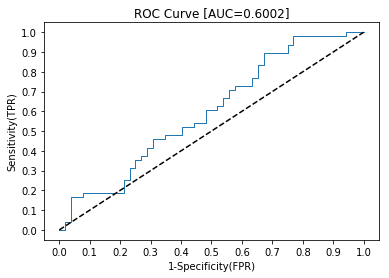

In [87]:
import numpy as np
import random
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import roc_auc_score, roc_curve, auc

from eipi10.ml2.predictor import *


y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])

print(y_true.shape)
print(y_scores.shape)

print(np.unique(y_true))
print(type_of_target(y_true))
print(type_of_target(y_scores))


print('sklearn auc: ', roc_auc_score(y_true, y_scores))
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print('手工计算 auc: ',np.trapz(tpr, fpr)) #手工计算auc

print('-'*100)
y_true = np.random.choice(2,  100)
y_scores = [0.2 + random.random() if p==1 else random.random() - 0.2  for p in y_true]
y_scores = np.array([random.random() if p>1 else (random.random() if p<0 else p)  for p in y_scores])
print('sklearn auc: ', roc_auc_score(y_true, y_scores))
# print('sklearn auc: ', auc(y_true, y_scores))

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print('手工计算 auc: ',np.trapz(tpr, fpr)) #手工计算auc



curve = EvaluateCurve(y_true, y_scores)                    
curve.plot_roc()

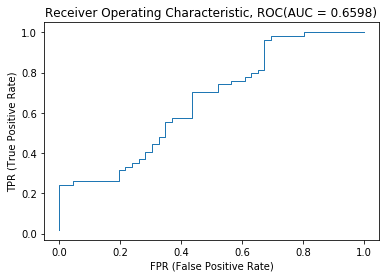

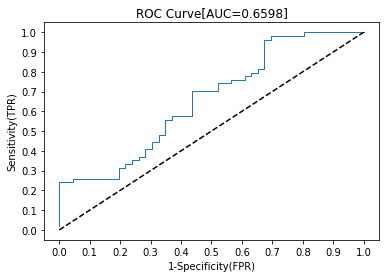

100
41
41


In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)   #计算auc
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
plt.plot(fpr, tpr, lw=1, label='ROC(area = %0.2f)' % (roc_auc))
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Receiver Operating Characteristic, ROC(AUC = %0.4f)"% (roc_auc))
plt.show()

curve = EvaluateCurve(y_true, y_scores)                    
curve.plot_roc()

print(len(y_scores))
print(len(fpr))
print(len(thresholds))


#### Precision-Recall Curve

(20,)
(20,)


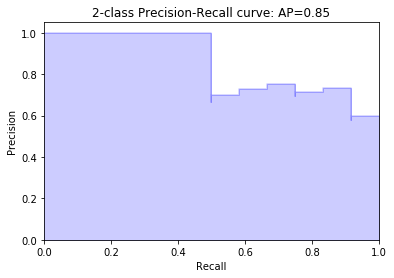

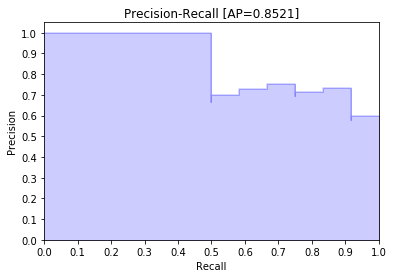

53
20


In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

y_test = np.random.choice(2,  20)
y_score = [0.25 + random.random() if p==1 else random.random() - 0.25  for p in y_test]
y_score = np.array([random.random() if p>1 else (random.random() if p<0 else p)  for p in y_score])

print(y_score.shape)
print(y_test.shape)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show() 

curve = EvaluateCurve(y_test, y_score)                    
curve.plot_pr()

print(len(thresholds))
print(len(pr_thresholds))

#### Average Precision (AP) 
$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$  
where $P_n$ and $R_n$ are the precision and recall at the nth threshold. 

AP：其实也相当于上面曲线的面积

In [135]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)
precision, recall = precision[::-1], recall[::-1]

print(np.trapz(precision, recall)) #手工计算auc

l = len(precision)
print(np.sum((recall[i+1]-recall[i])*precision[i+1] for i in range(l-1)))#手工计算auc 上面梯形计算面积的方法有些偏小，但大致的方向是一致的。

Average precision-recall score: 0.56
0.5298443568051411
0.5589357628573315


**自己实现的评估曲线**

### 1.17 BM25

Okapi BM25 是搜索引擎用来对匹配文档进行排序的函数，依据是每个文档与搜索词的相关度。BM 是 Best Matching (最佳匹配) 的缩写。这个方法是上世纪七八十年代在概率搜索的框架下被提出的。Okapi 是第一个使用这种方法的信息获取系统的名称。

BM25 是基于词频的方法；也就是说，它不考虑多个搜索词在文档里是不是靠近，只考虑它们各自的出现次数。BM25 不是单个函数：许多函数都可以叫 BM25，彼此之间有些形式和参数个数的差异。最常用的形式之一是

$\text{score}(D,Q) = \sum_{i=1}^n\text{IDF}(q_i)\cdot\left[\frac{f(q_i,D)\cdot\left(k_1+1\right)}{f(q_i,D) + k_1\cdot\left(1-b+b\cdot\frac{|D|}{\text{avgdl}}\right)}\right],$

其中各符号含义如下：

D: 文档  
Q: 搜索词 (多个)  
f(qi,D): qi 这个词在文档 D 中的出现次数  
|D|: D 的单词数  
avgdl: 整个文档库中文档的平均长度  
k1, b: 自由参数，一般取值范围是 k1∈[1.2,2.0], b=0.75  
IDF(qi): inverse document frequency，通常由下述公式计算  

$\text{IDF}(q_i) = \log\left(\frac{N-n(q_i)+0.5}{n(q_i) + 0.5}\right),$

这里 N 是文档库里总的文档数，n(qi) 是包含单词 qi 的文档个数。一个单词的 IDF 大，意味着这个单词只在较少文档中出现，也就意味着这个单词比较独特。
这里 IDF 的定义有个问题，那就是，如果一个词在超过半数的文档里出现，则其 IDF 是负数，于是这个词对 BM25 分数的贡献是负的。一般不希望这样的特性，所以当 IDF 为负数时可强行改为 0，或者一个比较小的正数，或者改用一种平滑过渡到 0 的函数形式。

[Okapi BM25, TF-IDF, 以及 ElasticSearch/Lucene 搜索结果的分数](http://fjdu.github.io/coding/2017/03/16/bm25-elasticsearch-lucene.html)  
[文本相似度-bm25算法原理及实现](https://www.jianshu.com/p/1e498888f505): 里面有代码实现

### 1.16 限定GPU内存的使用

####  Tensorflow

默认情况下，一个session会分配所有的GPU内存

**自动增加**  
```python
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
session = tf.Session(config=config)  
```

**固定分配**  
```
config = tf.ConfigProto()  
config.gpu_options.per_process_gpu_memory_fraction = 0.4  
session = tf.Session(config=config) 
```

如果是使用keras, 以下脚本。
```
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
```
---------------------

本文来自 悟乙己 的CSDN 博客 ，全文地址请点击：https://blog.csdn.net/sinat_26917383/article/details/75633754?utm_source=copy 

#### PyTorch



### 1.15 NLP平滑方法 
**历史**  
- 2018-06-17 Additive smoothing  
- 2018-07-17 Good-Turing estimate
- 2018-07-18 Kneser-Ney smoothing 总体看懂了，但细节之处，的确复杂。

总体上采用深度学习的方法比平滑方法的效果好的多。但这项技术还是必须要有所了解。

为了处理NLP建模过程中的稀疏性（Sparsity）问题，需要进行平滑化。而平滑方法可以分为三个大类：
    
- Add-One Smoothing（Laplacian Smoothing）
- Additive smoothing
- Good-Turing estimate（图灵平滑）
- Jelinek-Mercer smoothing (interpolation)
- Katz smoothing (backoff)
- Witten-Bell smoothing
- Absolute discounting
- Kneser-Ney smoothing(Strong Baseline Method基准方法)
    
    
**参考 **
- [自然语言处理中N-Gram模型的Smoothing算法](https://blog.csdn.net/baimafujinji/article/details/51297802): 高手的blog，对Kneser-Ney Smoothing等做了详细描述
- [Language Modeling with Smoothing](https://cocoxu.github.io/courses/5525_slides_spring17/10_advanced_smoothing.pdf): 这篇文章中比较了各个平滑方法（非常好），作者的观点如下。
    - Add-1 estimation is a blunt instrument 
        - So add-1 isn’t used for N-grams:
            -We’ll see better methods
        - But add-1 is used to smooth other NLP models
            - For text classification
            - In domains where the number of zeros isn’t so huge.    
    - Backoff:
        - use trigram if you have good evidence,
        - otherwise bigram, otherwise unigram
    - Interpolation:
        - mix unigram, bigram, trigram
        - Interpolation works better
        
- [NLP Lunch Tutorial: Smoothing](https://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)  
- NLP 笔记 - 平滑方法(Smoothing)小结  http://www.shuang0420.com/2017/03/24/NLP%20%E7%AC%94%E8%AE%B0%20-%20%E5%B9%B3%E6%BB%91%E6%96%B9%E6%B3%95(Smoothing)%E5%B0%8F%E7%BB%93/

**Add-One Smoothing ** 

比较简单，但总效果比较差的方法。

下面以bigram model为例说明

**  MLE **  

$ \begin{align} 
P_{MLE}\ (w_i|w_{i-1}) = \frac {c(w_{i-1} w_i)} {c(w_{i-1})}
\end{align}$

** Add-1 MLE **  

$ \begin{align} 
P_{MLE}\ (w_i|w_{i-1}) = \frac {c(w_{i-1} w_i) + 1} {c(w_{i-1}) + V}  \end{align} \\ 
V = \{w:c(w)>0\} \cup \{UNK\}   
$

V其实就是training中所有unique unigram的个数+1( V is the number of unique unigrams in the train corpus plus 1)


举个例子，假设语料库为下面三个句子

```
JOHN READ MOBY DICK
MARY READ A DIFFERENT BOOK
SHE READ A BOOK BY CHER
```

那么 JOHN READ A BOOK 这个句子的概率是：
![](http://ox5l2b8f4.bkt.clouddn.com/images/NLP%20%E7%AC%94%E8%AE%B0%20-%20%E5%B9%B3%E6%BB%91%E6%96%B9%E6%B3%95%28Smoothing%29%E5%B0%8F%E7%BB%93/1.jpg)

而 CHEN READ A BOOK 这个句子出现的概率是：
![](http://ox5l2b8f4.bkt.clouddn.com/images/NLP%20%E7%AC%94%E8%AE%B0%20-%20%E5%B9%B3%E6%BB%91%E6%96%B9%E6%B3%95%28Smoothing%29%E5%B0%8F%E7%BB%93/2.jpg)

如果使用加1平滑，那么概率就变成了：
![](http://ox5l2b8f4.bkt.clouddn.com/images/NLP%20%E7%AC%94%E8%AE%B0%20-%20%E5%B9%B3%E6%BB%91%E6%96%B9%E6%B3%95%28Smoothing%29%E5%B0%8F%E7%BB%93/3.jpg)


In [335]:
#  以下任务来自 https://www.coursera.org/learn/language-processing/supplement/fdxeI/perplexity-computation 
# 手工实现add one smooth

from nltk import ngrams
from nltk import FreqDist
import math

def get_grams(sentences, n=2):
    n_grams = []
    n_1_grams = []
    unigram = []
    for sentence in sentences:
        tokens = sentence.lower().split(' ') 
        for i in range(n-1):
            tokens = ['<s>'] + tokens            
        tokens = tokens + ["<e>"]    

        n_grams = n_grams + list(ngrams(tokens, n=n, pad_left=False, pad_right=False))
        n_1_grams = n_1_grams + list(ngrams(tokens, n=n-1, pad_left=False, pad_right=False))
        unigram = unigram + list(ngrams(tokens, n=1, pad_left=False, pad_right=False)) 
    return n_grams, n_1_grams, unigram

def show_most_common(dist, m=30):
    print('-'*50)
    for item in dist.most_common(m):
        print(item)

        
def likehood_estimate(train_sentences, test_sentence, n=2, verbose=False):    
    train_n_grams, train_n_1_grams, _ = get_grams(train_sentences, n=n)
    train_n_dist, train_n_1_dist = FreqDist(train_n_grams), FreqDist(train_n_1_grams)
    if verbose: show_most_common(train_n_dist)
    if verbose: show_most_common(train_n_1_dist)
    
    probs = []
    test_grams, _, _ = get_grams([test_sentence], n=n)
    prob = 1
    
    print('-'*50)
    for gram in test_grams:
        p = train_n_dist[gram]/train_n_1_dist[gram[0:-1]]
        if verbose: print(gram, train_n_dist[gram], gram[0:-1], train_n_1_dist[gram[0:-1]])
        prob = p*prob
        probs.append(p)
    perplexity = math.pow(prob, -1/(len(test_grams)-1))    
    return prob, perplexity, probs    

def add_one_smooth(train_sentences, test_sentence, n=2, verbose=False):
    train_n_grams, train_n_1_grams, train_unigram = get_grams(train_sentences, n=n)
    train_n_dist, train_n_1_dist, train_1_dist = FreqDist(train_n_grams), FreqDist(train_n_1_grams), FreqDist(train_unigram)
    if verbose: show_most_common(train_n_dist)
    if verbose: show_most_common(train_n_1_dist)
    if verbose: show_most_common(train_1_dist)
    v =  len(train_1_dist) - 1
    
    probs = []
    test_grams, _, _ = get_grams([test_sentence], n=n)
    prob = 1
    False
    print('-'*50)
    for gram in test_grams:
        p = (train_n_dist[gram]+1)/(train_n_1_dist[gram[0:-1]]+v)
        if verbose: print(gram, train_n_dist[gram], gram[0:-1], train_n_1_dist[gram[0:-1]])
        prob = p*prob
        probs.append(p)
    perplexity = math.pow(prob, -1/(len(test_grams)-1))    
    if verbose: print(len(test_grams)-1, v)
    return prob, perplexity, probs
    
train_sentences = ["This is the cat that killed the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the house that Jack built"
prob, perplexity, probs = add_one_smooth(train_sentences, test_sentence, 3)
print(prob, perplexity, probs)
assert(perplexity==11.887954313095586)  

  

--------------------------------------------------
2.9802322387695312e-08 11.887954313095586 [0.125, 0.125, 0.125, 0.0625, 0.125, 0.125, 0.125, 0.125]


In [336]:
import math
train_sentences = ["This is the cow with the crumpled horn that tossed the dog that worried the cat that killed the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the rat that worried the dog that Jack built"
prob, perplexity, probs = likehood_estimate(train_sentences, test_sentence, 2, verbose=False)
print(prob, perplexity, probs)
assert(math.isclose(prob, 1/6/7/6/7))

train_sentences = ["This is the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the house that Jack built"
prob, perplexity, probs = likehood_estimate(train_sentences, test_sentence, 2, verbose=False)
print(prob, perplexity, probs)
assert(math.isclose(perplexity, math.pow(1/3*1/3, -1/7)))
prob, perplexity, probs = add_one_smooth(train_sentences, test_sentence, 2)
print(prob, perplexity, probs)

train_sentences = ["This is the cat that killed the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the house that Jack built"
# prob, perplexity, probs = likehood_estimate(train_sentences, test_sentence, 3, verbose=False)  #
# print(prob, perplexity, probs)

train_sentences = ["This is the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the house that Jack built"
prob, perplexity, probs = add_one_smooth(train_sentences, test_sentence, 3, verbose=False)
print(prob, perplexity, probs)


--------------------------------------------------
0.0005668934240362811 1.9730415660093537 [1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 0.16666666666666666, 1.0, 0.14285714285714285, 1.0, 0.16666666666666666, 1.0, 1.0]
--------------------------------------------------
0.1111111111111111 1.3687381066422017 [1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 1.0]
--------------------------------------------------
1.3281030862990755e-07 9.602746388257104 [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.125, 0.14285714285714285, 0.125, 0.14285714285714285, 0.14285714285714285]
--------------------------------------------------
8.673326277871513e-08 10.205413747033983 [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]


In [337]:
import math
train_sentences = ["This is the cow with the crumpled horn that tossed the dog that worried the cat that killed the rat that ate the malt that lay in the house that Jack built"]
test_sentence  = "This is the rat that worried the dog that Jack built"
prob, perplexity, probs = likehood_estimate(train_sentences, test_sentence, 2)
print(prob, perplexity, probs, 1/6/7/6/7)
assert(math.isclose(prob, 1/6/7/6/7))

--------------------------------------------------
0.0005668934240362811 1.9730415660093537 [1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 0.16666666666666666, 1.0, 0.14285714285714285, 1.0, 0.16666666666666666, 1.0, 1.0] 0.0005668934240362812


**Good-Turing estimate（古德-图灵估计）**

摘自[Good-Turing估计](https://heshenghuan.github.io/2016/05/13/Good-Turing%E4%BC%B0%E8%AE%A1/)


古德-图灵（Good-Turing）估计法是很多平滑技术的核心，于1953年有古德（I.J.Good）引用图灵（Turing）的方法而提出来的。其基本思想是：对于没有看见的事件，我们不能认为它发生的概率就是零，因此我们从概率的总量（Probability Mass）中，分配一个很小的比例给这些没有看见的事件（如下图）。这样一来看的见概率总和就要小于1了，因此，需要将所有看见的事件概率调小一点。至于小多少，要根据“越是不可信的统计折扣越多”的方法进行。

![未看见](../../image/good-turing-event.png)

以统计词典中的每个词的概率为例，假设语料库中出现$r$次的词有$N_r$个，特别地，未出现的词数量为$N_0$。语料库的大小为$N$。那么很显然：

$$N = \sum_{r=1}^{\infty}{rN_r}$$


出现r次的词在整个语料库上的相对频度（Relative Frequency）则是$r/N$，如果不做任何处理，就以这个相对频度作为这些词的概率估计。

现在假设当$r$比较小时，它的估计可能不可靠，因此在计算出现r次的词的概率时，要使用一个更小的系数$d_r$（而不是直接使用$r$），古德图灵估计按照下面的公式计算$d_r$:

$$d_r = (r+1) \frac{N_{r+1}}{N_r}$$

显然有，

$$\sum_r d_r N_r = N$$

一般来说，出现一次的词的数量比出现两次的多，出现两次的比三次的多。这种规律称为Zipf定律（Zipf’s Law）。下图是一个小语料上出现r次的词的数量$N_r$和$r$的关系。

![Zipf's Law](../../image/zipfs_law.png)

可以看出$r$越大，词的数量$N_r$越小，即$N_{r+1}<N_r$。因此，一般情况下$d_r$<r，而$d_0>0$。这样就给未出现的词赋予了一个很小的非零值，从而解决了零概率的问题。同时下调了出现概率很低的词的概率。

当然，在实际的自然语言处理中，一般会设置一个阈值$k$，仅对出现次数小于$k$的词做上述调整。并且，因为实际语料的统计情况使得$N_{r+1}<N_r$不一定成立，$N_r=0$情况也可能出现，所以需要使用曲线拟合的方式替换掉原有的$N_r$，并使用如下Kartz退避公式计算$d_r$:

$$d_r = \frac{(r+1)\frac{N_{r+1}}{N_r}-r\frac{(k+1)N_{k+1}}{N_1}}{1-\frac{(k+1)N_{k+1}}{N_1}}, 1 \le r \le k$$



举例：

训练集合：T= {<s\>what is it what is small?}， |T|=8   
验证集合：V={what is it small ? <s\> flying birds are a bird.}， |V|=12   
在训练集合上，我们得到：  
$p(<s>)=p(it)=p(small)=p(?)=0.125$    
$p(what)=p(is)=0.25, 其他为0   $
  

如果不经过平滑处理，则验证集上两句子的概率分别为：  
$p(what\ is\ it?)=0.25*0.25*0.125*0.125≈0.001   $     
$p(it\ is\ flying.)=0.125*0.25*0*0=0  $
    
用古德-图灵算法进行平滑处理:

- 首先计算，各发生r次N元组类别的数目   
$N(0)=6,N(1)=4,N(2)=2 \\ 
N(i)=0,i>2:$  


- 其次，重新估计各概率值。   
    对于发生0次的事件概率：  
    $p(.)=p(flying)=p(birds)=p(are)=p(bird)=p(a)= (0+1)*N(0+1)/(8*N(0))=1*4/(8*6)≈0.083$

    对于发生1次的时间概率：  
    $p(it)=p(<s>)=p(small)=p(?)=(1+1)*N(1+1)/(8*N(1))=2*2 /(8*4)=0.125  $

    对于发生两次的时间概率：  
    $p(what)=Pr(is)=(2+1)*N(2+1)/(8*N(2))=3*0/(8*2)=0,  保持原值0.25 $
    

- 归一化处理:  

    $6*P0+4*P1+2*P2=1.5$  
  
    $p'(it)=p'(<s>)=p'(small)=p'(?)= 0.125/1.5 ≈0.08 \\
    p'(what)=p'(is)= 0.25/1.5 ≈0.17 \\ 
    p'(.)=p(flying)=p'(birds)=p'(are)=p'(bird)=p'(a) = 0.083/1.5  ≈0.06 $

    因此：  
    $p'(what\ is\ it?)=0.17*0.17*0.08*0.08≈0.0002  \\  p'(it\ is\ flying.) ≈ 0.08*0.17*0.06*0.06≈0.00004$


**Kneser-Ney Smoothing**

摘自[自然语言处理中N-Gram模型的Smoothing算法](https://blog.csdn.net/baimafujinji/article/details/51297802)

这种算法目前是一种标准的，而且是非常先进的平滑算法，它其实相当于是前面讲过的几种算法的综合。由于这个算法比较复杂，我们从一个直观上的例子来开始。假设我们使用 bigram 和 unigram 的插值模型来预测下面这个句子中空缺的一个词该填什么

I used to eat Chinese food with ______ instead of knife and fork.

直觉上你一定能猜到这个地方应该填 chopsticks（筷子）。但是有一种情况是训练语料库中，Zealand 这个词出现的频率非常高，因为 New Zealand 是语料库中高频词。如果你采用标准的 unigram 模型，那么显然 Zealand 会比 chopsticks 具有更高的权重，所以最终计算机会选择Zealand这个词（而非chopsticks）填入上面的空格，尽管这个结果看起来相当不合理。这其实就暗示我们应该调整一下策略，最好仅当前一个词是 New 时，我们才给 Zealand 赋一个较高的权值，否则尽管在语料库中 Zealand 也是高频词，但我们并不打算单独使用它。

如果说 $P(w)$ 衡量了$ w $这个词出现的可能性，那么我们现在想创造一个新的 unigram 模型，叫做 $P_{continuation}$ ，它的意思是将 $w$ 这个词作为一个新的接续的可能性。注意这其实暗示我们要考虑前面一个词（即历史）的影响。或者说，为了评估 $P_{continuation}$ （注意这是一个 unigram 模型），我们其实需要考察使用了 $w $这个词来生成的不同 bigram 的数量。注意这里说使用了$ w$ 这个词来生成的不同类型 bigram 的数量，是指当前词为$ w$ ，而前面一个词不同时，就产生了不同的类型。例如：w = “food”, 那么不同的 bigram 类型就可能包括 “chinese food”，“english food”，“japanese food”等。每一个 bigram 类型，当我们第一次遇到时，就视为一个新的接续（novel continuation）。

也就是说 $P_{continuation}$ 应该同所有新的接续（novel continuation）构成的集合之势（cardinality）成比例。所以，可知 

$$P_{continuation}(w_i)\propto \lvert {w_{i-1}:C(w_{i-1}w_i)>0}\rvert$$

如果你对此尚有困惑，我再来解释一下上面这个公式的意思。当前词是 $w_i$，例如“food”，由此构成的不同类型的 bigram 即为 $w_{i−1}w_i$，其中 $w_{i−1}$ 表示前一个词（preceding word）。显然，所有由 $w_{i−1}w_i$构成的集合的势，其实就取决于出现在$w_i$之前的不同的$w_{i−1}$ 的数量。
然后，为了把上面这个数变成一个概率，我们需要将其除以一个值，这个值就是所有 bigram 类型的数量，即$\lvert\{(w_{j−1},w_j):C(w_{j−1}w_j)>0\}\rvert $，这里大于0的意思就是“出现过”。于是有 

$$P_{continuation}(w_i)=\frac{\lvert \{w_{i-1}:C(w_{i-1}w_i)>0\}\rvert}{\lvert\{(w_{j-1},w_j):c(w_{j-1}w_j)>0\}\rvert}$$

当然，我们还可以采用下面这种等价的形式 

$$P_{continuation}(w_i)=\frac{\lvert \{ w_{i-1}:C(w_{i-1}w_i)>0\}\rvert}
{\sum_{w'_i} \lvert\{w'_{i-1}:C(w'_{i-1}w'_i)>0\}\rvert}$$

即所有不同的 bigram 的数量就等于出现在单词 $w'_i$ 前面的所有不同的词$w'_{i-1}$ 的数量。
如此一来，一个仅出现在 New 后面的高频词 Zealand 只能获得一个较低的接续概率（continuation probability）。由此，再结合前面给出的Absolute Discounting 的概率计算公式，就可以得出插值的 Kneser-Ney Smoothing 的公式，即 

$$P_{KN}(w_i|w_{i-1})=\frac{max(C(w_{i-1}w_i)-d,0)}{C(w_{i-1})}
+\lambda(w_{i-1})P_{continuation}(w_i)$$

其中，$max(C(w_{i-1}w_i)-d,0)$ 的意思是要保证最后的计数在减去一个 $d$ 之后不会变成一个负数。其次，我们将原来的 $P(w_i) $替换成了 $P_{continuation}(w_i)$。此外，$\lambda$ 是一个正则化常量，用于分配之前discount的概率值（也就是从高频词中减去的准备分给那些未出现的低频词的概率值）： 

$$\lambda(w_{i-1})=\frac{d}{C(w_{i-1})}\cdot \lvert \{w:C(w_{i-1},w)>0\}\rvert$$

如果用递归的方式重写出一个更加普适的泛化公式则有：

$$P_{KN}(w_i|w_{i-n+1}\cdots w_{i-1})=\frac{max(0,C_{KN}(w_{i-n+1} \cdots w_i) - d)}{C_{KN}(w_{i-n+1}\cdots w_{i-1})}
+\lambda(w_{i-n+1}\cdots w_{i-1})\cdot P_{KN}(w_i|w_{i-n+2}\cdots w_{i-1})$$

其中， 
$$\lambda(w_{i-n+1}\cdots w_{i-1})=\frac{d}{C_{KN}(w_{i-n+1}\cdots w_{i-1})}\cdot \lvert \{w:C_{KN}(w_{i-n+1} \cdots w_{i-1}w)>0\}\rvert$$

由于采用了上述这种递归的写法，我们需要定义一个计数函数 $C_{KN}$，它取决于在插值组合中的各阶 N-Gram 处于哪个层级。例如，假设我们现在所使用的插值模型是trigram，bigram 和 unigram 的组合，那么对于最高阶的 trigram 在计数时并不需要使用接续计数（采用普通计数即可），而其他低阶，即 bigram 和 unigram 则需要使用接续计数。这是因为在 unigram 中，我们遇到了一个 Zealand，我们可以参考它的 bigram，同理在 bigram，我还可以再参考它的 trigram，但是如果我们的插值组合中最高阶就是 trigram，那么现在没有 4-gram来给我们做接续计数。用公式表示即为： 

$$C_{KN}(\cdot)=\begin{cases}count(\cdot) &,for\quad the\quad highest\quad order\\
continuationcount(\cdot) &,for\quad all\quad other\quad lower\quad orders
\end{cases}$$

我们前面提到Kneser-Ney Smoothing 是当前一个标准的、广泛采用的、先进的平滑算法。这里我们所说的先进的平滑算法，其实是包含了其他以 Kneser-Ney 为基础改进、衍生而来的算法。其中，效果最好的Kneser-Ney Smoothing 算法是由Chen & Goodman（1998）提出的modified Kneser-Ney Smoothing 算法。很多NLP的开发包和算法库中提供有原始的Kneser-Ney Smoothing（也就是我们前面介绍的），以及modified Kneser-Ney Smoothing 算法的实现。有兴趣的读者可以查阅相关资料以了解更多。

推荐阅读和参考文献：  
[1] Speech and Language Processing. Daniel Jurafsky & James H. Martin, 3rd. Chapter 4  
[2] 本文中的一些例子和描述来自 北京大学 常宝宝 以及 The University of Melbourne “Web Search and Text Analysis” 课程的幻灯片素材    
[3] [A Kneser-Ney mini-example](http://idiom.ucsd.edu/~rlevy/lign256/winter2008/kneser_ney_mini_example.pdf) ： 这里有一个计算的例子，不清楚的时候可以看看。总体Kneser-Ney的确是一个复杂的方法。

### 1.14 TF-IDF

处理tf-idf要非常注意，转化后的数据是否正确。比如： TfidfVectorizer类中token_pattern默认是r"(?u)\b\w\w+\b"，它只会匹配长度两个以上的字符。

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

corpus=["I come to China to travel ", 
    "This is a car polupar in China ",          
    "I love tea and Apple ",   
    "The work is to write some papers in science "] 


tfidf2 = TfidfVectorizer()
re = tfidf2.fit_transform(corpus)
print(re.shape)
print(re[0:2])
print(re.toarray()[:, 0:6])
print( tfidf2.get_feature_names())

print('-'*100)
# corpus= [dict(Counter(line.split(' ')))  for line in corpus]
# print(corpus)

# tfidf2 = TfidfVectorizer()
# re = tfidf2.fit_transform(corpus)
# print(re.shape)
# print(re[0:2])
# print(re.toarray()[:, 0:6])
# print( tfidf2.get_feature_names())

(4, 19)
  (0, 4)	0.4424621378947393
  (0, 15)	0.697684463383976
  (0, 3)	0.348842231691988
  (0, 16)	0.4424621378947393
  (1, 3)	0.3574550433419527
  (1, 14)	0.45338639737285463
  (1, 6)	0.3574550433419527
  (1, 2)	0.45338639737285463
  (1, 9)	0.45338639737285463
  (1, 5)	0.3574550433419527
[[0.         0.         0.         0.34884223 0.44246214 0.        ]
 [0.         0.         0.4533864  0.35745504 0.         0.35745504]
 [0.5        0.5        0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.28113163]]
['and', 'apple', 'car', 'china', 'come', 'in', 'is', 'love', 'papers', 'polupar', 'science', 'some', 'tea', 'the', 'this', 'to', 'travel', 'work', 'write']
----------------------------------------------------------------------------------------------------


In [14]:
# gensim也有tfidf, 和上面比较一下
from gensim import models
from collections import Counter
from pprint import pprint
from collections import defaultdict


texts = [[word for word in document.lower().split()]
         for document in corpus]

# frequency = defaultdict(int)
# for text in corpus:
#     for token in text.split():
#         frequency[token] += 1
# print(frequency)
        
new_corpus = [  Counter(sentence).most_common()+ [('hello', 0.2*i+0.2)]  for i, sentence in enumerate(texts) ]      
pprint(new_corpus)
tfidf = models.TfidfModel(new_corpus)
print(tfidf)
print(tfidf[new_corpus[0]])   #看起来, tfidf的计算值和sklearn中的不同，原因何在？
print(tfidf[new_corpus[1]])   
print(tfidf[new_corpus[2]])   


2019-02-24 06:05:22,134: INFO: collecting document frequencies
2019-02-24 06:05:22,136: INFO: PROGRESS: processing document #0


[[('to', 2),
  ('china', 1),
  ('i', 1),
  ('travel', 1),
  ('come', 1),
  ('hello', 0.2)],
 [('this', 1),
  ('car', 1),
  ('a', 1),
  ('in', 1),
  ('china', 1),
  ('polupar', 1),
  ('is', 1),
  ('hello', 0.4)],
 [('love', 1),
  ('and', 1),
  ('i', 1),
  ('tea', 1),
  ('apple', 1),
  ('hello', 0.6000000000000001)],
 [('some', 1),
  ('the', 1),
  ('work', 1),
  ('to', 1),
  ('in', 1),
  ('science', 1),
  ('is', 1),
  ('write', 1),
  ('papers', 1),
  ('hello', 0.8)]]
TfidfModel(num_docs=4, num_nnz=30)
[('to', 0.5345224838248488), ('china', 0.2672612419124244), ('i', 0.2672612419124244), ('travel', 0.5345224838248488), ('come', 0.5345224838248488)]
[('this', 0.4588314677411235), ('car', 0.4588314677411235), ('a', 0.4588314677411235), ('in', 0.22941573387056174), ('china', 0.22941573387056174), ('polupar', 0.4588314677411235), ('is', 0.22941573387056174)]
[('love', 0.48507125007266594), ('and', 0.48507125007266594), ('i', 0.24253562503633297), ('tea', 0.48507125007266594), ('apple', 0.4850

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: %i format: a number is required, not str
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-pac

In [29]:
corpus1=["I come to China to travel", 
    "This is a car polupar in China",          
    "I love tea and Apple ",   
    "The work is to write some papers in science"] 
texts = [[word for word in document.lower().split()]
         for document in corpus1]     
print(texts)
new_corpus = [  Counter(sentence).most_common()  for sentence in texts ]     
print(new_corpus)

tfidf_model = models.TfidfModel(new_corpus)
tfidf_model[new_corpus[0]]

[['i', 'come', 'to', 'china', 'to', 'travel'], ['this', 'is', 'a', 'car', 'polupar', 'in', 'china'], ['i', 'love', 'tea', 'and', 'apple'], ['the', 'work', 'is', 'to', 'write', 'some', 'papers', 'in', 'science']]
[[('to', 2), ('come', 1), ('travel', 1), ('china', 1), ('i', 1)], [('a', 1), ('is', 1), ('this', 1), ('in', 1), ('car', 1), ('polupar', 1), ('china', 1)], [('love', 1), ('tea', 1), ('and', 1), ('i', 1), ('apple', 1)], [('papers', 1), ('in', 1), ('to', 1), ('work', 1), ('is', 1), ('write', 1), ('the', 1), ('science', 1), ('some', 1)]]


[('to', 0.5345224838248488),
 ('come', 0.5345224838248488),
 ('travel', 0.5345224838248488),
 ('china', 0.2672612419124244),
 ('i', 0.2672612419124244)]

In [260]:
# 中文: jieba + tfidf 

import jieba
import sys

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

raw_corpus = ["我来到北京清华大学",
          "他来到了网易杭研大厦",
          "小明硕士毕业于中国科学院",
          "我爱北京天安门",
          "中国已经崛起",
          "每一个中国人都爱中国",
           '我喜欢踢足球\n为甚恶魔     爱中国  已经崛起  '
         ]

print(raw_corpus[6])

corpus = [" ".join(jieba.cut(line, cut_all=False)) for line in raw_corpus]
print(corpus)
                   
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
print(tfidf.shape)

words = vectorizer.get_feature_names()

def show_document(corpus, tfidf):
    for i in range(len(corpus)):
        print('----Document %d----' % (i))
        for j in range(len(words)):
            if tfidf[i,j] > 1e-5:
                  print(words[j], tfidf[i,j])

show_document(corpus, tfidf)
       
corpus1 = ['中国 首都 是 北京']  
tfidf1 = vectorizer.transform(corpus1)
show_document(corpus1, tfidf1)


我喜欢踢足球
为甚恶魔     爱中国  已经崛起  
['我 来到 北京 清华大学', '他 来到 了 网易 杭研 大厦', '小明 硕士 毕业 于 中国科学院', '我 爱 北京 天安门', '中国 已经 崛起', '每 一个 中国 人 都 爱 中国', '我 喜欢 踢足球 \n 为 甚 恶魔           爱 中国     已经 崛起    ']
(7, 18)
----Document 0----
北京 0.5382813427107301
来到 0.5382813427107301
清华大学 0.6484646421965249
----Document 1----
大厦 0.5206467559864713
来到 0.43218152024617124
杭研 0.5206467559864713
网易 0.5206467559864713
----Document 2----
中国科学院 0.5
小明 0.5
毕业 0.5
硕士 0.5
----Document 3----
北京 0.6387085483562188
天安门 0.7694487573949885
----Document 4----
中国 0.5172690941469574
崛起 0.60515811332262
已经 0.60515811332262
----Document 5----
一个 0.5760335528744375
中国 0.8174260492318878
----Document 6----
中国 0.32113915333960336
喜欢 0.4526083494381602
崛起 0.3757037997205483
已经 0.3757037997205483
恶魔 0.4526083494381602
踢足球 0.4526083494381602
----Document 0----
中国 0.649749587643745
北京 0.7601483232611799


### 1.13 jieba常用函数
https://github.com/fxsjy/jieba

词性表： http://www.niumou.com.cn/183 


In [4]:
#三种模式：全模式，精确模式， # 搜索引擎模式
import jieba

seg_list = jieba.cut("我来到北京清华大学", cut_all=True)
print("Full Mode: " + "/ ".join(seg_list))  # 全模式

seg_list = jieba.cut("我来到北京清华大学", cut_all=False)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式

seg_list = jieba.cut("他来到了网易杭研大厦")  # 默认是精确模式
print(", ".join(seg_list))

seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式
print(", ".join(seg_list))

seg_list = jieba.cut_for_search("我来到北京清华大学")  # 搜索引擎模式
print(", ".join(seg_list))



Full Mode: 我/ 来到/ 北京/ 清华/ 清华大学/ 华大/ 大学
Default Mode: 我/ 来到/ 北京/ 清华大学
他, 来到, 了, 网易, 杭研, 大厦
小明, 硕士, 毕业, 于, 中国, 科学, 学院, 科学院, 中国科学院, 计算, 计算所, ，, 后, 在, 日本, 京都, 大学, 日本京都大学, 深造
我, 来到, 北京, 清华, 华大, 大学, 清华大学
|, [, 2, ], :,  , 我, 想, 给, 我, 的, 机器, 15, -, AK030TX, 加个, 内存条, ，, 你, 能, 给, 我查, 下, 是, 什么, 规格, 的, 吗, ？


In [18]:
#用户词典
#encoding=utf-8
from __future__ import print_function, unicode_literals
import sys
sys.path.append("../")
import jieba
jieba.load_userdict("userdict.txt")
import jieba.posseg as pseg

jieba.add_word('石墨烯')
jieba.add_word('凱特琳')
jieba.del_word('自定义词')

test_sent = (
"李小福是创新办主任也是云计算方面的专家; 什么是八一双鹿\n"
"例如我输入一个带“韩玉赏鉴”的标题，在自定义词库中也增加了此词为N类\n"
"「台中」正確應該不會被切開。mac上可分出「石墨烯」；此時又可以分出來凱特琳了。\n"
"|[2]: 我想给我的机器15-AK030TX加个内存条，你能给我查下是什么规格的吗？\n"
"您可以尝试卸载一下无线网的驱动  然后在尝试链接一下无线尝试一下\n"
"已经发送啦,稍后看看邮件的垃圾箱还有收件箱两个地方哈\n"
)
print(test_sent)
print("="*40)
words = jieba.cut(test_sent)
print('/'.join(words))

print("="*40)



李小福是创新办主任也是云计算方面的专家; 什么是八一双鹿
例如我输入一个带“韩玉赏鉴”的标题，在自定义词库中也增加了此词为N类
「台中」正確應該不會被切開。mac上可分出「石墨烯」；此時又可以分出來凱特琳了。
|[2]: 我想给我的机器15-AK030TX加个内存条，你能给我查下是什么规格的吗？
您可以尝试卸载一下无线网的驱动  然后在尝试链接一下无线尝试一下
已经发送啦,稍后看看邮件的垃圾箱还有收件箱两个地方哈

李小福/是/创新办/主任/也/是/云计算/方面/的/专家/;/ /什么/是/八一双鹿/
/例如/我/输入/一个/带/“/韩玉赏鉴/”/的/标题/，/在/自定义/词库/中/也/增加/了/此/词为/N/类/
/「/台中/」/正確/應該/不會/被/切開/。/mac/上/可/分出/「/石墨烯/」/；/此時/又/可以/分出/來/凱特琳/了/。/
/|/[/2/]/:/ /我/想/给/我/的/机器/15/-/AK030TX/加个/内存条/，/你/能/给/我查/下/是/什么/规格/的/吗/？/
/您/可以/尝试/卸载/一下/无线网/的/驱动/ / /然后/在/尝试/链接/一下/无线/尝试/一下/
/已经/发送/啦/,/稍后/看看/邮件/的/垃圾箱/还有/收件箱/两个/地方/哈/



In [ ]:
result = pseg.cut(test_sent)

for w in result:
    print(w.word, "/", w.flag, ", ", end=' ')

print("\n" + "="*40)

terms = jieba.cut('easy_install is great')
print('/'.join(terms))
terms = jieba.cut('python 的正则表达式是好用的')
print('/'.join(terms))

print("="*40)
# test frequency tune: 如果有些词在一定场景存在变化，这种用户词典，可能更加的科学。
testlist = [
('今天天气不错', ('今天', '天气')),
('如果放到post中将出错。', ('中', '将')),
('我们中出了一个叛徒', ('中', '出')),
]

for sent, seg in testlist:
    print('/'.join(jieba.cut(sent, HMM=False)))
    word = ''.join(seg)
    # suggest_freq(segment, tune=True) 可调节单个词语的词频，使其能（或不能）被分出来。
    print('%s Before: %s, After: %s' % (word, jieba.get_FREQ(word), jieba.suggest_freq(seg, True)))
    print('/'.join(jieba.cut(sent, HMM=False)))
    print("-"*40)

print("="*40)
print('/'.join(jieba.cut('如果放到post中将出错。', HMM=False)))

jieba.suggest_freq(('中', '将'), False)
print('/'.join(jieba.cut('如果放到post中将出错。', HMM=False)))

print('/'.join(jieba.cut('「台中」正确应该不会被切开', HMM=False)))
jieba.suggest_freq('台中', False)

print('/'.join(jieba.cut('「台中」正确应该不会被切开', HMM=False)))

words =jieba.cut("我们中出了一个叛徒",HMM=False)
print('/'.join(words))
jieba.suggest_freq(('中出'),True)
words =jieba.cut("我们中出了一个叛徒",HMM=False)
print('/'.join(words))

### 1.12 BLEU分数 

BLEU，全称为Bilingual Evaluation Understudy（双语评估替换），是一个比较候选文本翻译与其他一个或多个参考翻译的评价分数。
尽管BLEU一开始是为翻译工作而开发，但它也可以被用于评估文本的质量，这种文本是为一套自然语言处理任务而生成的。

**惩罚因子**

$ BP = \begin{equation}  
\left\{  
\begin{array}{lcl}  
 1        & &  if\ c>r \\  
 e^{(1-r/c)} & &  if\ c<=r  
\end{array}  
\right.  
\end{equation}   $  

这里的c是机器译文的词数，r是参考译文的词数

$
BLEU = BP \cdot exp \left( \sum\limits_{n=1}^N w_n \log p_n \right)
$  
[浅谈用Python计算文本BLEU分数](https://cloud.tencent.com/developer/article/1042161)  
[机器翻译自动评估-BLEU算法详解](https://blog.csdn.net/qq_31584157/article/details/77709454)

In [49]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import math

import inspect
print(inspect.getargspec(sentence_bleu))

def manual_bleu(gram_scores, weights):    
    return np.exp(np.sum((np.log(gram_scores) * np.array(weights))))
    
def bleu(reference, candidate, all_weights=[(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]):   
    print("--------------------------------------------------------------------------")    
    gram1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    gram2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    gram3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    gram4 = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))

    gram_scores = np.array([gram1, gram2, gram3, gram4])
    print('gram_scores: %s' % gram_scores)
    
    bp = 1 if len(reference[0]) < len(candidate) else  math.exp(1-len(reference[0])/len(candidate))
    for weights in all_weights:            
        score = sentence_bleu(reference, candidate, weights=weights)   
        manual_score_no_bp = manual_bleu(gram_scores, weights)
        manual_score = bp *  manual_score_no_bp
        print("weights: %s - score: %f - manual score: %f  - manual score(no bp): %f  " % (weights, score, manual_score, manual_score_no_bp) )


# reference = [['this', 'is', 'a', 'test']]
# candidate = ['this', 'is', 'a', 'test']
# bleu(reference, candidate)

# reference = [['this', 'is', 'small', 'test']]
# candidate = ['this', 'is', 'a', 'test']
# bleu(reference, candidate)

# one word different
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'fast', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
bleu(reference, candidate, all_weights=[(0.25, 0.25, 0.25, 0.25)])

# two words different
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'fast', 'brown', 'fox', 'jumped', 'over', 'the', 'sleepy', 'dog']
bleu(reference, candidate, all_weights=[(0.25, 0.25, 0.25, 0.25)])

# shorter candidate
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the']
bleu(reference, candidate, all_weights=[(0.25, 0.25, 0.25, 0.25)])
#这里有个问题，
#weights: (0.25, 0.25, 0.25, 0.25) - score: 0.751477 - manual score: 0.564718 
# 手工计算的结果和library中的结果有差异，经过检查发现manual score如果不乘于bp，则结果能匹配上。难道是library里有bug.
            
# longer candidate
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'from', 'space']
bleu(reference, candidate, all_weights=[(0.25, 0.25, 0.25, 0.25)])


ArgSpec(args=['references', 'hypothesis', 'weights', 'smoothing_function', 'auto_reweigh'], varargs=None, keywords=None, defaults=((0.25, 0.25, 0.25, 0.25), None, False))
--------------------------------------------------------------------------
gram_scores: [0.88888889 0.75       0.71428571 0.66666667]
weights: (0.25, 0.25, 0.25, 0.25) - score: 0.750624 - manual score: 0.750624  - manual score(no bp): 0.750624  
--------------------------------------------------------------------------
gram_scores: [0.77777778 0.5        0.42857143 0.33333333]
weights: (0.25, 0.25, 0.25, 0.25) - score: 0.485492 - manual score: 0.485492  - manual score(no bp): 0.485492  
--------------------------------------------------------------------------
gram_scores: [0.75147729 0.75147729 0.75147729 0.75147729]
weights: (0.25, 0.25, 0.25, 0.25) - score: 0.751477 - manual score: 0.564718  - manual score(no bp): 0.751477  
--------------------------------------------------------------------------
gram_scores: [0.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  


## 1.11 Five Types of RNN(RNN的几种类型)

![five rnn](../../image/five_rnn.png)

 1. Element-wise sequence classification
 2. Unconditional sequence generation
 3. Sequence classification
 4. Conditional sequence generation
 5. Sequence translation(sequence to sequence)

## 1.10 word2vec



**Bengio2003的论文《A Neural Probabilistic Language Model》**
![Bengio NPLM](../../image/bengio_nnlm.png)

**如何找到一种简单有效的词向量学习方法**

首先根据具体任务，选一个领域相似的语料，在这个条件下，语料越大越好。然后下载一个 word2vec 的新版（14年9月更新），语料小（小于一亿词，约 500MB 的文本文件）的时候用 Skip-gram 模型，语料大的时候用 CBOW 模型。最后记得设置迭代次数为三五十次，维度至少选 50，就可以了。

语料对词向量的影响比模型的影响要重要得多得多得多。语料方面，很多论文都提到语料越大越好，我们发现，语料的领域更重要。领域选好了，可能只要 1/10 甚至 1/100 的语料，就能达到一个大规模泛领域语料的效果。有时候语料选的不对，甚至会导致负面效果（比随机词向量效果还差）。文章还做了实验，当只有小规模的领域内语料，而有大规模的领域外语料时，到底是语料越纯越好，还是越大越好。在我们的实验中，是越纯越好。这一部分实验数据比较丰富，原文相对清楚一些。


**相关**
- [[NLP] 秒懂词向量Word2vec的本质](https://zhuanlan.zhihu.com/p/26306795)
- [Deep Learning in NLP （一）词向量和语言模型](http://licstar.net/archives/328)
- [word2vec 中的数学原理详解](https://blog.csdn.net/itplus/article/details/37969519)  说实话，还是把这个看完后，感觉到一些安心
- [Deep Learning实战之word2vec](http://techblog.youdao.com/?p=915#LinkTarget_699)
- [基于神经网络的词和文档语义向量表示方法研究](../../paper/Word_and_Document Embeddings_based_on_Neural_Network_Approaches.pdf)  可以作为更深入全面的扩展阅读，这里不仅仅有 word2vec，而是把词嵌入的所有主流方法通通梳理了一遍
- [《How to Generate a Good Word Embedding?》导读](http://licstar.net/archives/620#comment-1542) 
- [word2vec Parameter Learning Explained](https://arxiv.org/pdf/1411.2738)  理论完备由浅入深非常好懂，且直击要害，既有 high-level 的 intuition 的解释，也有细节的推导过程
- [Word and Document Embeddings based on Neural Network Approaches](https://arxiv.org/pdf/1611.05962)
- [基于神经网络的词和文档语义向量表示方法研究](https://arxiv.org/ftp/arxiv/papers/1611/1611.05962.pdf) 对于初学者，的确是文本向量化的集大成之文。


## 1.9 什么是avoidable bias ？


<img src="../../image/reduce_bias_variance.png">

如果human-level的error不同，比如：

top one expert: 0.1%
expert1 : 0.2%
expert2 : 0.3%
normal human: 1%
选择最小的error作为human-level的error。这是因为这代表了人类的最高水平，理论上非常接近Bayes Possible Error。

Human-level error is a proxy for Bayes error. 机器学习的准确度 Accuracy 提升有两道坎, 一道是 human-level, 人类非常擅长一些工作, 比如判断是猫与否, 因此将其设为第一道坎, 表达了对人类的尊重; 另一道坎是 贝叶斯可能误差 Bayes Possible Error, 这是学习任务的理论最优值, 可以说是, 看得到摸不着的天花板.

## 1.8 why is gradients sometimes vanishing or exploding? 
![a](../../image/vanish_explode_gradient.png)

上面的这个解释非常形象，但$W$取了一个对角矩阵，还不够普遍，下面进一步解释一下。

设$W = P\lambda P^\mathrm{T}$，则$W^{l-1}=P\lambda^{l-1}P^\mathrm{T}$， $\hat{y} = W^{l}P\lambda^{l-1}P^\mathrm{T}X $

这个时候的导数，还是取决于特征值，如果特征值大于1，则导数就非常大，如果特征值小于1，则导数趋近于0。
所以好的weight initialization策略非常重要



** 应对梯度爆炸的方法**

- Gradient Clipping
![a](../../image/gradient_clipping.png)
![a](../../image/gradient_clipping_threshold.png)

- Truncated BPTT：避免梯度爆炸。当反向传播时，仅仅只反向传播一定步骤。
![a](../../image/full_bptt.png)
![a](../../image/truncated_bptt.png)

carry hidden states forward in time forever, but only backpropagate for some smaller number of steps. 

** 应对梯度消失的方法**
- LSTM， GRU
- Relu
![resistant](../../image/relu_resistant.png)
![derivative](../../image/derivative.png)
- Initialization
![orthogonal](../../image/w_orthogonal.png)
![w value](../../image/w_value.png)
- Skip Connnections(Resnet)
![skip_connection](../../image/skip_connection.png)


## 1.7 why does deep learning break bias variance trade-off（both low bias and low varance）

![bias_variance_tradeoff](../../image/bias_variance_tradeoff.png)

在深度学习里，可以打破bias variance trade-off。

1 消除High Bias。采用更大更深的网络，更长的train时间（更好的优化方法），更加适合的神经网络架构。  
2 消除High Variance。采用更多的数据，更大正则化系数，更加适合的神经网络架构。


## 1.6 Big Data大数据中Train，Dev和Test Sets的比例发生了变化

![train_dev_test](../../image/train_dev_test.png)

对于Big Data（$>1000,000$），三者比例变成98：1：1，甚至99.5：0.25：0.25。尽可能的利用数据，来训练出一个更好的模型。另外需要注意的一点就是Train sets与Dev Sets, Test Sets的数据分布可以不同, 但要保证 Dev Set和 Test Set 这两个集合来自同一数据分布，以确保我们能够通过在 Dev Set上的评估能正确反映在 Test Set 的性能。

## 1.5 为什么Regularization会抑制overfitting?

![prevent_overfitting](../../image/prevent_overfitting.png)

正则项中$\lambda$越大，则$W$更加趋近于0，则$Z$会变得更小，则$Z$的取值范围在图中圆圈范围。而$tanh, sigmoid$在该范围趋近于线性，这样整个模型显得更加简单，从而减少过拟合。

## 1.4 $\textbf{为什么正则项中，往往没有b}$?

因为$W$里面已经包含了大量的参数，$b$就可以忽略。这个解释似乎有些牵强。在PRML中说： “通常系数w0从正则化项中省略，因为包含w0会使得结果依赖于⽬标变量原点的选择。w0也可以被包含在正则化项中，但是必须有⾃⼰的正则化系数”。 还是迷糊。

在线性分类器中，w如果


## 1.3 Huffman编码 

霍夫曼编码（英语：Huffman Coding），是一种用于无损数据压缩的熵编码（权编码）算法。由大卫·霍夫曼在1952年发明。

![构建Huffman树](../../image/huffman_tree_build.gif)

在电文传输中，需要将电文中出现的每个字符进行二进制编码。采用霍夫曼编码可以使得发送的二进值编码尽可能短。

**相关**
- [霍夫曼树和霍夫曼编码原理](https://blog.csdn.net/sddxqlrjxr/article/details/51114809)

## 1.2 CNN发展史  2018-05-03

希望能够通读下面的网络的相关论文，并同时做实验重现论文，

![cnn发展](../../image/cnn-progress.png)

- [【卷积神经网络-进化史】从LeNet到AlexNet](https://blog.csdn.net/cyh_24/article/details/51440344) 上图来自于这篇blog
- [CNN的近期进展与实用技巧（上）](https://mp.weixin.qq.com/s?__biz=MzI1NTE4NTUwOQ==&mid=2650324619&idx=1&sn=ca1aed9e42d8f020d0971e62148e13be&scene=1&srcid=0503De6zpYN01gagUvn0Ht8D#wechat_redirect)


## 1.1 Deep Learning is a language 深度学习是一门语言   2018-05-02

正在学习了国立高等经济大学（后面简称高经大学）的系列深度学习课程，感觉真的不错，真的不得不佩服俄罗斯人。和NG的课程比较，高经大学的课程内容更加丰富，简明，干货满满，作业量甚至是NG的3倍。NG的课程更加的大众，很多东西都不敢讲深一点。或许对于现阶段的我来说，高经大学的课程更加适合。课程中，有很多启发，比如，在intro-to-deep-learning第二周中提出：deep learning is a language。然后举了两个例子。

![Bottleneck layer](../../image/dl-is-a-language0.png)
#### Bottle neck layer  
这是一个预测汽车价格的网络。有两类数据，第一类是Raw features，是汽车图片，第二类是汽车的high level属性，比如：品牌，配置，型号，年限等等。一般我们认为第二类数据更加代表了汽车的价格，第一类数据由于涉及到拍照的条件影响，可能误判的可能性比较大，这种情况下，我们要加大对第二类数据的权重。通过引入bottleneck layer能够简明实现这一逻辑。

![Bottleneck layer](../../image/dl-is-a-language1.png)

利用Age gender等数据量巨大的数据集和训练神经网络，然后用这个网络再来训练小的数据集，这样可以得到更好的结果。其实这也是迁移学习，不是第一次看到，但看了这个图之后，感觉更加的有触动，首先，age， gender是一些高级特性，很容易得大量数据，而从道理上说，年纪，性别等对衣服的选择有很多的影响。采用这个迁移学习，实现了高级特性和低层特性的融合。真的非常巧妙。联想到之前绘画风格的转换融合，感觉深度学习网络是一种连接器，用它来连接相关的一些属性，建立这些属性深层的联系。真的要开阔思路了。

通过两个例子可以感到，深度神经网络是一种语言，用它来连接我们的各种数据，用它来表达我们对数据关系的理解。这不就是一种语言吗？
